In [ ]:
import os
import pandas as pd
import numpy as np
import sys
from collections import OrderedDict
from IPython.display import display
import matplotlib.pyplot as plt
from numba import jit, prange, njit, config

sys.setrecursionlimit(20000)

from numba.typed import Dict, List

from scripts import test_mutation, calculate_all_fitnesses, calculate_fitness, genotype_hash,deep_copy_genotype, mutate_genotype_inplace, assert_equality_of_hashes
from scripts import random_int, NODE_TYPE, GENOTYPE_TYPE, best_n_items, create_full_tree_from_genome, seed
from scripts import create_n_genotypes, crossover_numba, selection_tournament
from tqdm.notebook import tqdm

#load_and_print_csvs_from_folders()
#test_n_creation()


In [ ]:
test_mutation()

#test_fitness()
#test_crossover()

In [ ]:
def mutate_genotype(parent_genotype, grammar, probability, empty_genotype ):
    parameter_hash = genotype_hash(parent_genotype)
    parameter_string = ""
    sorted_keys = parent_genotype.keys()

    # Create a string representation of the genotype
    genotype_str = ""
    for key in sorted_keys:
        genotype_str += key + ":"
        # genotype_str += ",".join(str(val) for val in genotype_param[key])
        for i in range(len(parent_genotype[key])):
            genotype_str += "," + str(parent_genotype[key][i])
        genotype_str += ";"

    offspring_genotype = deep_copy_genotype(parent_genotype, empty_genotype.copy())

    #parent_genotype["<expr"] =  parent_genotype["<start>"]
    offspring_genotype_hash = genotype_hash(offspring_genotype)

    #print(f"pre mutation: Parent hash: {parameter_hash} To be mutated hash: {offspring_genotype_hash}")

    #print("Offspring genotype: ", offspring_genotype)
    mutate_genotype_inplace(offspring_genotype, grammar, probability)

    offspring_genotype_hash = genotype_hash(offspring_genotype)
    parameter_hash_2 = genotype_hash(parent_genotype)

    #print(f"post mutation: Parent hash: {parameter_hash_2} Mutated hash: {offspring_genotype_hash}")
    try:
        assert_equality_of_hashes(parameter_hash, parameter_hash_2)
    except Exception as e:
        print("Hash not equal after mutation, some race condition occured")
        #print("Parent genotype: ", parent_genotype)
        #print("Pararent original genotype ", genotype_str)
        #print("Offspring genotype: ", offspring_genotype)
    #print("Parent genotype: ", parent_genotype)
   # raise Exception("Stop")
    return offspring_genotype

index_to_variable_name = {
    0: "best_fitness",
    1: "worst_fitness",
    2: "avg_fitness",
    3: "better_than_father",
    4: "worse_than_father",
    5: "num_repeated",
    6: "best_elite",
    7: "worst_elite",
    8: "avg_elite",
    9: "num_elite",
    10: "survivors"
}


def parse_df(case_df):
    # y is the last column from the df, extract it to y
    y = case_df.iloc[:, -1].to_numpy()

    # drop the last column from the df, and store the rest in X
    X = case_df.drop(case_df.columns[-1], axis=1)
    variable_matrix = X.to_numpy()

    return variable_matrix, y

@njit()
def median_absolute_deviation(data):
    median = np.median(data)
    deviations = np.abs(data - median)
    mad = np.median(deviations)
    return mad

test_file = "synth1/synth1-test.csv"

def selection_lexicase_wrapper(gnotype_list, grammar, NODE_TYPE, GENOTYPE_TYPE):
    df_test = pd.read_csv(test_file, header=None)
    variable_values_test, y_values_test = parse_df(df_test)
    return selection_epsilon_lexicase(gnotype_list, variable_values_test, y_values_test, grammar, NODE_TYPE, GENOTYPE_TYPE)
@njit
def get_random_indices(num_cases):
    # Generate a list of indices
    indices = np.arange(num_cases)

    # Create a copy of indices for shuffling
    shuffled_indices = indices.copy()

    # Perform Fisher-Yates shuffle
    for i in range(num_cases):
        # Get a random index
        j = np.random.randint(i, num_cases)

        # Swap i-th and j-th elements
        shuffled_indices[i], shuffled_indices[j] = shuffled_indices[j], shuffled_indices[i]

    return shuffled_indices

@njit
def selection_epsilon_lexicase(genotype_list, variables_values_test, y_values_test, grammar, NODE_TYPE, GENOTYPE_TYPE, epsilon=None, maximize=False):
    num_individuals = len(genotype_list)

    # possible test cases
    num_cases = len(y_values_test)

    candidates = list(range(num_individuals))

    case_indices = get_random_indices(num_cases)
    last_index = 0

    # more than one candidate and there are cases left to evaluate
    while len(candidates) > 1 and last_index < num_cases:

        current_case_index = case_indices[last_index]
        last_index += 1

        # Evaluate the fitness of the remaining candidates for the current case

        # create empty list of genotypes
        candidate_list = [GENOTYPE_TYPE.copy() for _ in range(len(candidates))]

        for i in range(len(candidates)):
            candidate = candidates[i]
            #copied_genotype = deep_copy_genotype(genotype_list[candidate], GENOTYPE_TYPE.copy())
            copied_genotype = genotype_list[candidate]
            candidate_list[i] = copied_genotype

        current_variable_values = [variables_values_test[current_case_index]]
        current_y = [y_values_test[current_case_index]]

            #candidate_fitness, _ = calculate_fitness(current_variable_values, current_y,copied_genotype, grammar, NODE_TYPE, GENOTYPE_TYPE)
        current_case_fitness = calculate_all_fitnesses(candidate_list, current_variable_values, current_y, grammar, NODE_TYPE, GENOTYPE_TYPE )

        best_fitness = min(current_case_fitness) if not maximize else max(current_case_fitness)

        if epsilon is None:
            epsilon = median_absolute_deviation(current_case_fitness)

        # Remove candidates with fitness worse than the best for the current case
        candidates = [candidate for idx, candidate in enumerate(candidates) if current_case_fitness[idx] <= best_fitness + epsilon]

        #for idx, candidate in enumerate(candidates):
        #    if current_case_fitness[idx] <= best_fitness + epsilon:
        #        candidates.append(candidate)
    if len(candidates) > 1:
        picked_index = random_int(0, len(candidates) - 1)
        return candidates[picked_index]
    else:
        return candidates[0]


def next_generation(genotype_list,
                    grammar: dict,
                    p_mutation: float,
                    p_crossover: float,
                    elite_percentage: float,
                    variables_values: np.ndarray,
                    y_values: np.ndarray,
                    tournament_size: int,
                    print_run_logs=False):

    population_size = len(genotype_list)

    def calculate_single_fitness(genotype):
        rmse, _ = calculate_fitness(variables_values, y_values, genotype, grammar, NODE_TYPE, GENOTYPE_TYPE)
        return rmse

    # Calculate fitness for all genotypes
    fitness_list = calculate_all_fitnesses(genotype_list, variables_values, y_values, grammar, NODE_TYPE, GENOTYPE_TYPE)

    # print("After fitness genotypes: ")
    #
    # for i in range(len(genotype_list)):
    #     print("\nGenotype: ", i)
    #     print_resumed_genotype(genotype_list[i])
    # print("\n\n\n")

    unique, counts = np.unique(fitness_list, return_counts=True)



    # Count number of repeated items
    num_repeated = np.sum(counts) - len(counts)

    # Metrics: Best and worst fitness
    best_fitness = np.min(fitness_list)
    worst_fitness = np.max(fitness_list)

    # Metrics: Average fitness
    avg_fitness = np.mean(fitness_list)


    # Select the elite individuals
    num_elite = int(population_size * elite_percentage)
    elite_indices = best_n_items(fitness_list, num_elite)
    elite_genotypes = [genotype_list[idx] for idx in elite_indices]

    elite_fitness = [fitness_list[idx] for idx in elite_indices]

    best_elite = np.min(elite_fitness)
    worst_elite = np.max(elite_fitness)
    avg_elite = np.mean(elite_fitness)

    # Tournament selection for survivors
    survivor_index = selection_lexicase_wrapper(genotype_list, grammar, NODE_TYPE, GENOTYPE_TYPE)
    survivors_indices = [survivor_index]
    #survivors_indices = selection_tournament(fitness_list, tournament_size)

    survivor_hashes = [genotype_hash(genotype_list[idx]) for idx in survivors_indices]

    survivors_genotypes = [genotype_list[idx] for idx in survivors_indices]


    worse_than_father = 0
    better_than_father = 0

    survivors = len(survivors_genotypes)

    # Reproduce, mutate, and crossover to create new offspring
    new_genotypes = []
    while len(new_genotypes) < population_size - num_elite:
        if print_run_logs:
            print("\n\nPopulation size: ", len(new_genotypes))
        r = np.random.random()
        parent_idx = np.random.randint(0, len(survivors_genotypes))
        parent_genotype = survivors_genotypes[parent_idx]
        #print_resumed_genotype(parent_genotype)
        if print_run_logs:
            print(f"Hash for parent: {survivor_hashes[parent_idx]}")

        if r < p_mutation:
            if print_run_logs:
                print("Mutating...")
            # Mutate
            offspring_genotype = mutate_genotype(parent_genotype, grammar, p_mutation, GENOTYPE_TYPE)
        elif r < p_mutation + p_crossover:
            if print_run_logs:
                print("Crossover...")
            # Crossover
            parent2_idx = np.random.randint(0, len(survivors_genotypes))

            attemps = 0
            max_attemps = 10
            while parent2_idx == parent_idx and attemps < max_attemps:
                parent2_idx = np.random.randint(0, len(survivors_genotypes))
                attemps += 1
            if attemps == max_attemps:
                if print_run_logs:
                    print("Couldn't find a different parent to crossover, doing parthenogenesis")
                # If we couldn't find a different parent, just mutate
                parent2_idx = parent_idx

            if print_run_logs:
                print(f"Hash for parent 2: {survivor_hashes[parent2_idx]}")

            parent2_genotype = survivors_genotypes[parent2_idx]
            #print_resumed_genotype(parent_genotype)
            #print_resumed_genotype(parent2_genotype)
            # print("++++++++++ end parents")
            offspring_1, offspring_2 = crossover_numba(parent_genotype, parent2_genotype, p_crossover, GENOTYPE_TYPE)

            #print_resumed_genotype(offspring_1)
            #print_resumed_genotype(offspring_2)

            parents_mean_fitness = (fitness_list[parent_idx] + fitness_list[parent2_idx]) / 2

            offspring_1_fitness = calculate_single_fitness(offspring_1)
            offspring_2_fitness = calculate_single_fitness(offspring_2)
            if print_run_logs:
                print("Created offspring with fitness: ", offspring_1_fitness, " and ", offspring_2_fitness)
            if offspring_1_fitness < parents_mean_fitness:
                better_than_father += 1
            else:
                worse_than_father += 1
            if offspring_2_fitness < parents_mean_fitness:
                better_than_father += 1
            else:
                worse_than_father += 1

            offspring_genotype = offspring_1
            new_genotypes.append(offspring_2)
        else:
            if print_run_logs:
                print("Reproducing...")
            # Reproduce
            offspring_genotype = deep_copy_genotype(parent_genotype, GENOTYPE_TYPE.copy())

        new_genotypes.append(offspring_genotype)

    # Combine elite and new offspring to create the next generation
    next_gen = elite_genotypes + new_genotypes

    # take the extra genotypes out
    if len(next_gen) > population_size:
        fitness_list_next_gen = calculate_all_fitnesses(next_gen, variables_values, y_values, grammar, NODE_TYPE, GENOTYPE_TYPE)
        worst_individuals = selection_tournament(fitness_list_next_gen, len(fitness_list_next_gen), True)
        if print_run_logs:
            print("Worst individuals for removal: ", worst_individuals)
        for idx in worst_individuals:
            del next_gen[idx]



    variables = np.array([
        best_fitness,
        worst_fitness,
        avg_fitness,
        better_than_father,
        worse_than_father,
        num_repeated,
        best_elite,
        worst_elite,
        avg_elite,
        num_elite,
        survivors
    ])
    if print_run_logs:
        for i, value in enumerate(variables):
            print(f"{index_to_variable_name[i]}: {value}")

        print("Next gen length: ", len(next_gen))

    return next_gen, variables


genotypes, grammar = create_n_genotypes(20, 3, 2)

# print("Original genotypes: ")
# for i in range(len(genotypes)):
#     print("\nGenotype: ", i)
#     print_resumed_genotype(genotypes[i])
# print("\n\n\n")

test_data = np.array([[-1.23592861, -1.36410559],
                      [-0.60259712, -0.60758157],
                      [2.80419539, 2.66919459],
                      [-0.22628393, -2.97797806],
                      [2.0402239, -0.59282888]])

test_y = np.array([6.51571868, 1.14283484, 40.67709954, 7.42636336, 9.6026114])

next_gen, _ = next_generation(genotypes, grammar, 0.3, 0.6, 0.1, test_data, test_y, 2, True)

In [11]:

def genetic_programming(num_generations, population_size, max_depth, p_mutation, p_crossover, elite_percentage, variables_values, y_values, tournament_size, silent_run=False):

    num_variables = len(variables_values[0])
    #print("Number of variables: ", num_variables)

    # Create the grammar
    genotype_list, grammar = create_n_genotypes(population_size, max_depth, num_variables)
    used_grammar = grammar
    # Initialize the genotypes
    current_genotypes = genotype_list

    # Define the statistics array to store the statistics for each generation
    stats_columns = len(index_to_variable_name)

    stats_shape = (num_generations, stats_columns)
    stats = np.zeros(shape=stats_shape, dtype=np.float64)

    iterator_wrapper = tqdm(range(num_generations), desc="Generations") if not silent_run else range(num_generations)

    # Run the algorithm for the specified number of generations
    for generation in iterator_wrapper:
        if not silent_run:
            print(f"\n=== Generation {generation + 1} ===")
        current_genotypes, current_stats = next_generation(current_genotypes, grammar, p_mutation, p_crossover, elite_percentage, variables_values, y_values, tournament_size, False)

        # Store the statistics for the current generation
        stats[generation, :] = current_stats

    return stats, current_genotypes, grammar

# read csv from inside synth1, called synth1-train.csv

df = pd.read_csv("synth1/synth1-train.csv", header=None)
display(df.head())

variable_matrix, y = parse_df(df)


stats, final_genotypes, used_grammar = genetic_programming(200, 100, 5, 0.2, 0.7, 0.1, variable_matrix, y, 10)


,0,1,2
0,-1.235929,-1.364106,6.515719
1,-0.602597,-0.607582,1.142835
2,2.804195,2.669195,40.677100
3,-0.226284,-2.977978,7.426363
4,2.040224,-0.592829,9.602611


Generations:   0%|          | 0/200 [00:00<?, ?it/s]


=== Generation 1 ===

=== Generation 2 ===

=== Generation 3 ===

=== Generation 4 ===

=== Generation 5 ===

=== Generation 6 ===

=== Generation 7 ===

=== Generation 8 ===

=== Generation 9 ===

=== Generation 10 ===

=== Generation 11 ===

=== Generation 12 ===

=== Generation 13 ===

=== Generation 14 ===

=== Generation 15 ===

=== Generation 16 ===

=== Generation 17 ===

=== Generation 18 ===

=== Generation 19 ===

=== Generation 20 ===

=== Generation 21 ===

=== Generation 22 ===

=== Generation 23 ===

=== Generation 24 ===

=== Generation 25 ===

=== Generation 26 ===

=== Generation 27 ===

=== Generation 28 ===

=== Generation 29 ===

=== Generation 30 ===

=== Generation 31 ===

=== Generation 32 ===

=== Generation 33 ===

=== Generation 34 ===

=== Generation 35 ===

=== Generation 36 ===

=== Generation 37 ===

=== Generation 38 ===

=== Generation 39 ===

=== Generation 40 ===

=== Generation 41 ===

=== Generation 42 ===

=== Generation 43 ===

=== Generation 44 =

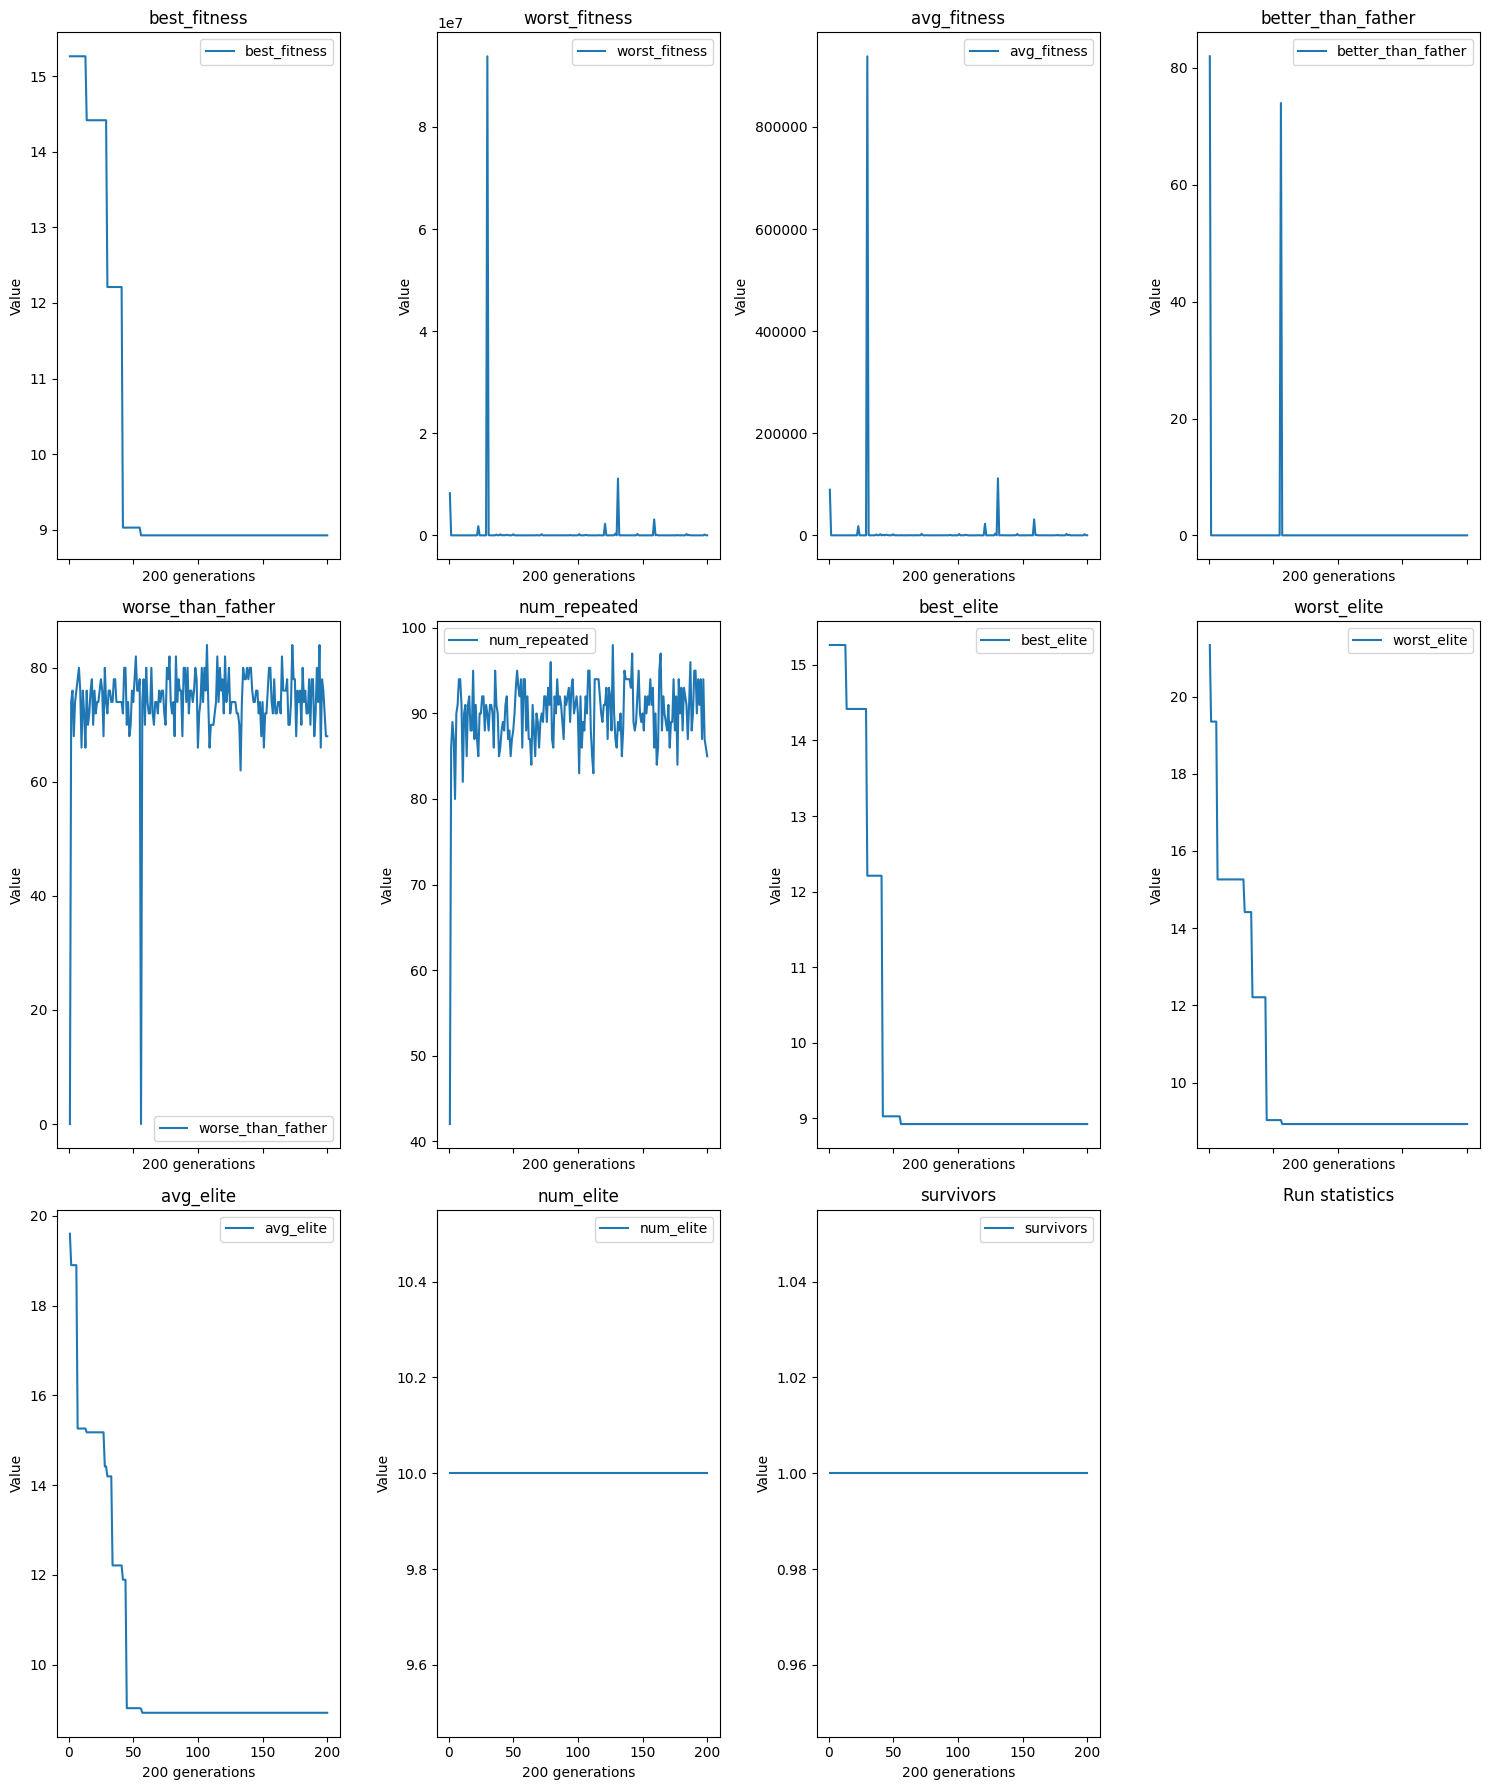

In [12]:
import math

def plot_stats(stats, index_to_variable_name):
    num_generations, num_stats = stats.shape

    num_cols = 4
    num_rows = math.ceil(num_stats / num_cols)

    # Create a subplot for each statistic in a mosaic grid
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6 * num_rows), sharex=True)
    axs = axs.flatten()  # Flatten the array to make it easier to work with

    # Plot the statistics on the corresponding subplot
    for i in range(num_stats):
        axs[i].plot(range(1, num_generations + 1), stats[:, i], label=index_to_variable_name[i])
        axs[i].set_title(index_to_variable_name[i])
        axs[i].set_xlabel(f"{num_generations} generations")
        axs[i].set_ylabel("Value")
        axs[i].legend()

    # If there are empty subplots, make them invisible
    for i in range(num_stats, len(axs)):
        axs[i].axis("off")

    # Adjust the layout of the subplots
    fig.tight_layout()
    plt.title("Run statistics")
    # Show the plot
    plt.show()

plot_stats(stats, index_to_variable_name)

In [ ]:
def run_and_collect_data(max_depth=3, p_mutation=0.05, p_crossover=0.09, elite_percentage=0.1, variables_values=variable_matrix, y_values=y, tournament_size=10):

    stats_list = []
    final_genotypes_list = []
    final_used_grammar = None

    generations = 40
    population_size = 50
    random_iterations = 30

    best_fitness_experiment = 0
    best_fitness_value = 10000000
    base_seed = 0
    for i in tqdm(range(random_iterations), desc="Random iterations"):
            base_seed += 1
            seed(base_seed)
            np.random.seed(base_seed)

            stats, final_genotypes, used_grammar = genetic_programming(generations, population_size, max_depth, p_mutation, p_crossover, elite_percentage, variables_values, y_values, tournament_size)
            stats_list.append(stats)
            final_genotypes_list.append(final_genotypes)
            final_used_grammar = used_grammar

            # get the best fitness from the last generation
            best_fitness_current = stats[-1, 0]
            if best_fitness_current < best_fitness_value:
                best_fitness_value = best_fitness_current
                best_fitness_experiment = i
            print("Case: ", i, " best fitness: ", best_fitness_current)
            plot_stats(stats, index_to_variable_name)

    # get the run with the best fitness overall
    best_genotypes = final_genotypes_list[best_fitness_experiment]


    # get the best genotype from the final generation of the best experiment
    fitness_list = calculate_all_fitnesses(best_genotypes, variable_matrix, y, grammar, NODE_TYPE, GENOTYPE_TYPE)

    # get the index of the best genotype
    best_index = best_n_items(fitness_list, 1)

    best_genotype = final_genotypes[best_index[0]]

    # print the best genotype
    print("Final function: ")
    copied_best = deep_copy_genotype(best_genotype, GENOTYPE_TYPE.copy())
    create_full_tree_from_genome(copied_best, final_used_grammar, NODE_TYPE, True)

    best_stats = stats_list[best_fitness_experiment]

    plot_stats(best_stats, index_to_variable_name)
#run_and_collect_data(3, 0.05, 0.9, 0.1, variable_matrix, y, 10)
plot_stats(stats, index_to_variable_name)

In [ ]:
def run_random_variations(train_filename, run_parameters, base_seed=0):
    df_train = pd.read_csv(train_filename, header=None)

    variable_matrix, y = parse_df(df_train)

    stats_list = []
    final_genotypes_list = []
    final_used_grammar = None

    print(f"Experiments with  {run_parameters['generations']} generations and population size {run_parameters['population_size']}")
    random_iterations = 10

    best_fitness_experiment = 0
    best_fitness_value = 10000000
    base_seed = base_seed
    for i in tqdm(range(random_iterations), desc="Random iterations"):
        base_seed += 1
        seed(base_seed)
        np.random.seed(base_seed)

        stats, final_genotypes, used_grammar = genetic_programming(run_parameters['generations'], run_parameters['population_size'], run_parameters["max_depth"], run_parameters["p_mutation"], run_parameters["p_crossover"], run_parameters["elite_percentage"], variable_matrix, y, run_parameters["tournament_size"], True)
        stats_list.append(stats)
        final_genotypes_list.append(final_genotypes)
        final_used_grammar = used_grammar

        # get the best fitness from the last generation
        best_fitness_current = stats[-1, 0]
        if best_fitness_current < best_fitness_value:
            best_fitness_value = best_fitness_current
            best_fitness_experiment = i


    aggregate = np.mean(stats_list, axis=0)

    stds_problem = np.std(stats_list, axis=0)

    print("Stds of the problem across generations")
    for i in range(len(index_to_variable_name)):
        print(f"{index_to_variable_name[i]}: {stds_problem[-1, i]}")


    print(f"Mean values across {random_iterations} random seed variations")
    plot_stats(aggregate, index_to_variable_name)
    print("Best experiment")
    plot_stats(stats_list[best_fitness_experiment], index_to_variable_name)

    return aggregate,stats_list[best_fitness_experiment],  final_genotypes_list[best_fitness_experiment], final_used_grammar



run_parameters = {
    "generations": 40,
    "population_size": 100,
    "max_depth": 5,
    "p_mutation": 0.2,
    "p_crossover": 0.6,
    "elite_percentage": 0.1,
    "tournament_size": 2
}
agg, best_gen_stats, best_genotypes, grammar = run_random_variations("synth1/synth1-train.csv", run_parameters, 0)

In [ ]:
def plot_test_fitness_per_genome(genotype_list, grammar, test_filename="synth1/synth1-train.csv"):
    df_test = pd.read_csv(test_filename, header=None)

    variable_matrix, y = parse_df(df_test)
    fitness_list = calculate_all_fitnesses(genotype_list, variable_matrix, y, grammar, NODE_TYPE, GENOTYPE_TYPE)

    print("Genotypes: ", len(genotype_list))
    for i, g in enumerate(genotypes):
        print(f"For the {i}th genotype, function is", sep=" ")
        copied_g = deep_copy_genotype(g, GENOTYPE_TYPE.copy())
        create_full_tree_from_genome(copied_g, grammar, NODE_TYPE, True)
    print(fitness_list)
    x_values = range(len(fitness_list))
    y_values = np.array(fitness_list)
    mean_value = np.mean(y_values)

    plt.bar(x_values, y_values, color='skyblue', edgecolor='black')
    plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean')

    plt.xlabel('Genotype Index')
    plt.ylabel('Fitness')
    plt.title('Comparison with test case')
    plt.ylim(bottom=0)
    plt.grid(axis='y', linestyle='--')
    plt.legend()
    plt.show()

copy_best_genotypes = best_genotypes
plot_test_fitness_per_genome(copy_best_genotypes, grammar, "synth2/synth2-test.csv")

# Esse método funcionava bem, mas como refatorei para usar a lexicase, o genotipo que ele utilizava nao funciona mais e quebra...